This tutorial is about
- Define fermion systems
- Use determinant to learn fermion ground states

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

lattice = qtx.sites.Square(4, is_fermion=True) # fermion lattice
N = lattice.nsites

In [2]:
from quantax.symmetry import ParticleConserve, SpinInverse, C4v, Trans2D

# Hubbard model
H = qtx.operator.Hubbard(U=4)

# determinant with 8 electrons
model = qtx.model.Determinant(Nparticle=8)

state = qtx.state.Variational(
    model,
    symm=ParticleConserve([4, 4]), # 4 spin-up, 4 spin-down
    max_parallel=32768, # maximum forward batch on each machine
)

# new samples proposed by electron hopping
sampler = qtx.sampler.NeighborExchange(state, 1000)
tdvp = qtx.optimizer.TDVP(state, H)

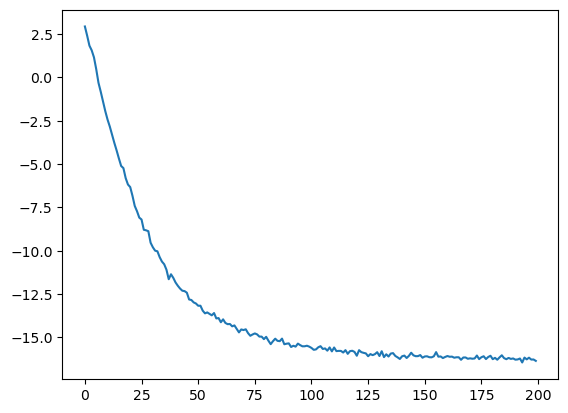

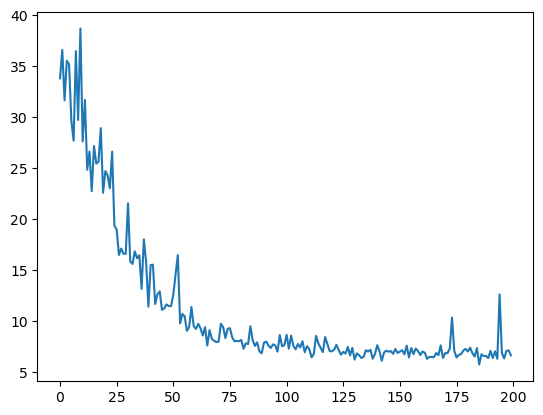

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 0.01)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [4]:
# symmetrize the trained NQS
# The ground state sector is in the B1 representation
symm = ParticleConserve([4, 4]) + Trans2D() + SpinInverse() + C4v("B1")

symm_state = qtx.state.Variational(
    state.models,
    symm=symm,
    max_parallel=32768,
)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000)
tdvp = qtx.optimizer.TDVP(symm_state, H)

2024-09-12 22:37:22.354290: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.15 = s64[1000,256]{1,0} reduce(s64[1000,256,32]{2,1,0} %broadcast.299, s64[] %constant.5), dimensions={2}, to_apply=%region_12.576, metadata={op_name="jit(forward_fn)/jit(main)/vmap(jit(symmetrize))/jit(_permutation_sign)/reduce_prod[axes=(2,)]" source_file="/tmp/ipykernel_2897307/2253274435.py" source_line=11}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-09-12 22:37:22.518333: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.164114139s
Constant folding an instruct

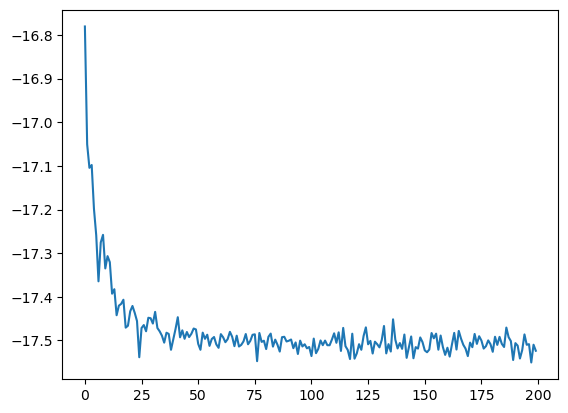

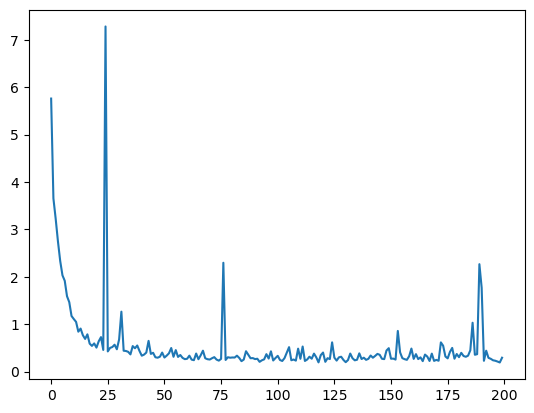

In [5]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 0.01)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [6]:
# check result by ED
E, wf = H.diagonalize(symm)
print(E[0])

/home/locao/miniconda3/envs/main/lib/python3.9/site-packages/quantax/symmetry/symmetry.py:269: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  self.basis.make()


-17.534897796641225
